In [ ]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126284 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no

In [1]:

import matplotlib.pyplot as plt

# 폰트 설정
import matplotlib.font_manager as fm

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

def set_font(): 
    # 폰트 설정
    font_path='/System/Library/Fonts/AppleGothic.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=10)
    plt.rcParams['font.family'] = 'AppleGothic'  # macOS
    plt.rcParams['axes.unicode_minus'] = False
    
set_font()

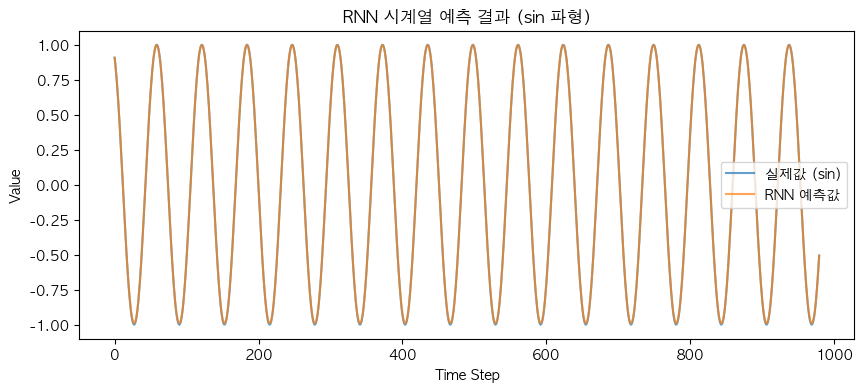

In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# 시계열 데이터 생성
seq_length = 20
x = np.linspace(0, 100, 1000)
data = np.sin(x)
X = []
y = []
for i in range(len(data)-seq_length):
    X.append(data[i:i+seq_length])
    y.append(data[i+seq_length])
X = np.array(X)
y = np.array(y)

X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1) # Add unsqueeze(-1) here
y_tensor = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# RNN 모델
class SineRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1)

model = SineRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# 학습 (여기선 10 epoch, 실습 시 조정 가능)
for epoch in range(10):
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

# 전체 데이터에 대한 예측
model.eval()
with torch.no_grad():
    y_pred = []
    for i in range(len(X)):
        input_seq = torch.tensor(X[i], dtype=torch.float32).unsqueeze(0).unsqueeze(-1)  # shape (1, seq_length, 1) - Keep this as it was correct for the prediction loop
        pred = model(input_seq)
        y_pred.append(pred.item())
    y_pred = np.array(y_pred)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(y, label='실제값 (sin)', alpha=0.7)
plt.plot(y_pred, label='RNN 예측값', alpha=0.7)
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('RNN 시계열 예측 결과 (sin 파형)')
plt.show()